# RuLSIFでの重み付け
*Relative unconstrained least-squares importance fitting*の略。重みをカーネル関数の足し合わせ(係数未知)として、この係数を真の相対重要度（密度比）との２乗誤差を最小化するという学習基準に基づいて学習する。二乗誤差を学習基準にすることで、ロバストな重み付が学習できるそう(杉山先生の資料(2013)より)

実装は[こちら](http://allmodelsarewrong.org/RuLSIF.html)を拝借している

密度比推定の論文は、求めているものは密度比$\frac{p_{test}(x)}{p_{train}(x)}$になるので, entropy estimatorでの重みの総和1制約のようなものは存在しない

### コードの追試（１次元での密度比推定）

In [101]:
from pyRULSIF import *
from pylab import *

In [102]:
# x_nu: samples from numerator(test data)
# x_de: samples from denominator(train data)
# x_re: reference sample
# alpha: alpha defined in relative density ratio
# sigma_list, lambda_list: parameters for model selection
# b: number of kernel basis
# fold: number of fold for cross validation

In [103]:
np.random.seed(1)
# generate data.
x_nu = randn(1, 50)*.25 - 1
x_de = randn(1, 100)*.5
x_re = array([arange(-1.5, 1.5, .05)])

In [104]:
# using normal ULSIF, which is RULSIF with alpha = 0.
alpha = 0
PE, w, s = R_ULSIF(x_nu, x_de, c_[x_re, x_nu, x_de], alpha,
                   sigma_list(x_nu, x_de), lambda_list(), x_nu.shape[1], 5)

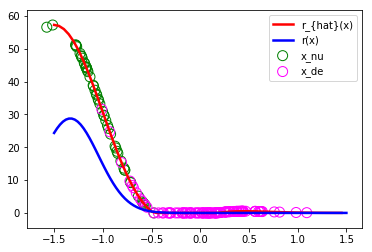

alpha =  0
divergence =  19.84959541447472


In [105]:
# plotting with true density ratio
w_re = w[0:x_re.shape[1]]
plot(x_re.T, w_re, label='r_{hat}(x)', linewidth=2.5, color='red')
w_nu = w[x_re.shape[1]:x_re.shape[1]+x_nu.shape[1]]
scatter(x_nu, w_nu, label='x_nu', color='green', facecolors='none', s=100)
w_de = w[x_re.shape[1]+x_nu.shape[1]:]
scatter(x_de, w_de, label='x_de', color='magenta', facecolors='none', s=100)

x_disp = linspace(-1.5, 1.5, 100)
plot(x_disp, norm_pdf(x_disp, -1, .25)/norm_pdf(x_disp, 0, .5),
     linewidth=2.5, label='r(x)', color='blue')
legend()
show()

print('alpha = ', alpha)
print('divergence = ', PE)

### 2次元以上でもRuLSIFがworkするか確認

In [12]:
np.random.seed(123)
x = np.random.multivariate_normal(mean = [0,0], cov = [[1,0],[0,1]], size = 300)
y = np.random.multivariate_normal(mean = [1.5,1.5], cov = [[1,0],[0,1]], size = 100)

In [13]:
x_re_2d = np.concatenate((np.linspace(-4,4,500)[:,np.newaxis], np.linspace(-4,4,500)[:,np.newaxis]), axis = 1)

In [14]:
PE, w, s = R_ULSIF(y.T, x.T, c_[x_re_2d.T, y.T, x.T], alpha,
                   sigma_list(x_nu, x_de), lambda_list(), x_nu.shape[1], 5)

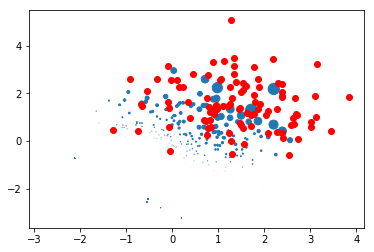

In [15]:
plt.scatter(x[:,0], x[:,1],  s = w[600:900]*10)
plt.plot(y[:,0], y[:,1], 'ro')

いけますた

# 一次元タスクでのRuLSIFとMCEWの比較

## 元データ生成
No Bias Left Behind: Covariate Shift Adaptation for Discriminative 3D Pose Estimationでのtoy practiceでの設定

In [74]:
import autopep8
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import itertools as it
%matplotlib inline

In [75]:
def gen_x(y):
    return y + 0.3 * np.sin(2*np.pi*y) + np.random.normal(loc=0.0, scale=0.05, size=len(y))

In [294]:
np.random.seed(123)
# data size setting
data_size_train = 200
data_size_test = 100

# generate train /test data
test_y = np.concatenate((np.random.normal(0.9, scale=0.025, size=int(data_size_test/2)),
                         np.random.normal(0.1, scale=0.025, size=int(data_size_test/2))))
test_x = gen_x(test_y)

train_y = np.random.uniform(size=data_size_train)
train_x = gen_x(train_y)

Text(0,0.5,'y')

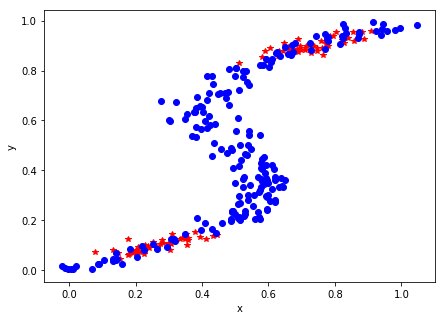

In [295]:
plt.figure(figsize=(7, 5))
plt.plot(test_x, test_y, 'r*', label='test')
plt.plot(train_x, train_y, 'bo', label='train')
plt.xlabel('x')
plt.ylabel('y')

(array([ 4., 19., 14., 10.,  3.,  1.,  9., 16., 15.,  9.]),
 array([0.07757773, 0.16058668, 0.24359564, 0.3266046 , 0.40961355,
        0.49262251, 0.57563146, 0.65864042, 0.74164938, 0.82465833,
        0.90766729]),
 <a list of 10 Patch objects>)

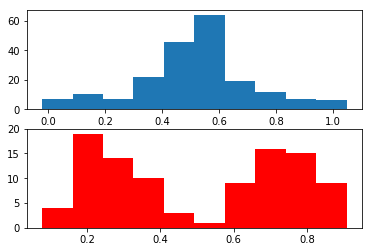

In [296]:
plt.subplot(2,1,1)
plt.hist(train_x)
plt.subplot(2,1,2)
plt.hist(test_x, color = 'r')

(array([96.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  2., 98.]),
 array([0.0103789 , 0.10662574, 0.20287258, 0.29911942, 0.39536626,
        0.4916131 , 0.58785994, 0.68410678, 0.78035362, 0.87660046,
        0.97284731]),
 <a list of 10 Patch objects>)

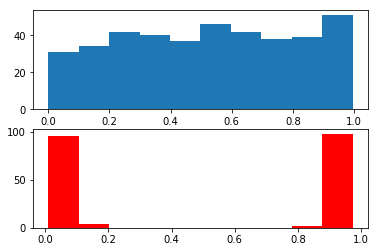

In [81]:
plt.subplot(2,1,1)
plt.hist(train_y)
plt.subplot(2,1,2)
plt.hist(test_y, color = 'r')

## 2 Kernel regresson(重みなし)

***カーネル回帰モデル***

$f(x;A) = A^Tk(x)$

で表される。この時、
$k(x)=[1, K(x,x_1^{tr}), K(x,x_2^{tr}), \cdots K(x, x_{n_{tr}}^{tr})]^T$の場合、

モデルパラメータ$A$は、

$ \hat{A}= (\tilde{K}^{tr}W(\tilde{K}^{tr})^T+\gamma I)\tilde{K}^{tr}W(Y^{tr})^T $

で解析的に求まる。ここで、

$\tilde{K}^{tr}=[k(x_1^{tr}), k(x_2^{tr}), \cdots,k(x_{n_{tr}}^{tr})], Y^{tr}=[y_1^{tr}, \cdots, y_{n_{tr}}^{tr}]$である

In [297]:
import numpy as np
from scipy.spatial import distance

### 学習

In [317]:
def learn_KR(train_x, response, sigma, gamma = 0.01, weight = None):
    # train_x is n_train_x ×　n_dim dimension array
    # weight is 1-d array
    # sigma is scalar value
    # gamma is scalar value
    if weight is None:
        W = np.eye(len(train_x))
    else:
        W = np.diag(weight)
    K = np.concatenate((np.ones(len(train_x))[np.newaxis, :],
                    np.exp(-distance.cdist(train_x, train_x)**2/2/sigma**2)))

    _left = np.linalg.inv(np.dot(np.dot(K, W), K.T) + gamma*np.eye(len(train_x)+1) )
    _right = np.dot(np.dot(K, W), response.T)

    return(np.dot(_left, _right))

### テスト

In [318]:
def pred_KR(test, train,sigma, A):
    basis = np.concatenate((np.ones(len(test))[np.newaxis, :],
                np.exp(-distance.cdist(train, test)**2/2/sigma**2)))
    y = np.dot(A, basis)
    return(y)

### visualize

In [310]:
train = train_x[:,np.newaxis]
response = train_y
test = test_x[:, np.newaxis]

In [343]:
A = learn_KR(train, response, sigma = 0.01, gamma = 0.3)

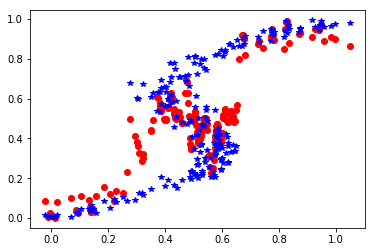

In [344]:
plt.plot(train, pred_KR(train, train, sigma, A), 'ro', label = 'pred')
plt.plot(train, train_y, 'b*', label = 'true')

0.1905459258844776

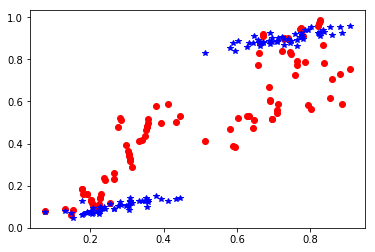

In [405]:
# 学習パラメータにかなり敏感のものですな
plt.plot(test, pred_KR(test, train, sigma, A), 'ro', label = 'pred')
plt.plot(test, test_y, 'b*', label = 'true')
np.sqrt((pred_KR(test, train, sigma, A) - test_y)**2).mean()

# Importance weighted KR(RuLSIF)

In [346]:
grid = np.linspace(0,1,100)[:,np.newaxis].T

### $\alpha = 0.3$

In [407]:
train = train_x[:,np.newaxis].T
test = test_x[:,np.newaxis].T
alpha = 0.3
PE, lsif_w, s = R_ULSIF(test, train, c_[grid, test, train], alpha,
                   sigma_list(test, train), lambda_list(), test.shape[1], 5)

## 学習

In [408]:
train = train_x[:, np.newaxis]
response = train_y
test = test_x[:, np.newaxis]

In [409]:
lsif_A = learn_KR(train, response,sigma = 0.01, gamma = 0.3, weight = lsif_w[-len(train):])

## テスト

0.18752411425341362

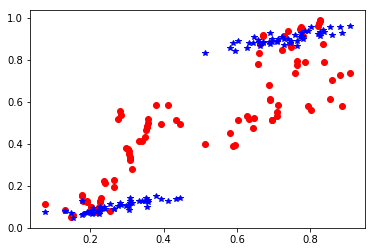

In [410]:
# 学習パラメータにかなり敏感のものですな
plt.plot(test, pred_KR(test, train, sigma, lsif_A), 'ro', label = 'pred')
plt.plot(test, test_y, 'b*', label = 'true')
np.sqrt((pred_KR(test, train, sigma, lsif_A) - test_y)**2).mean()

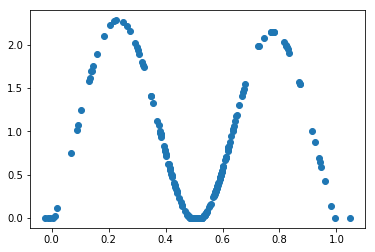

In [396]:
# 各データ点の重み
plt.plot(train, lsif_w[-len(train):], 'o')

### $\alpha = 0$

In [411]:
train = train_x[:,np.newaxis].T
test = test_x[:,np.newaxis].T
alpha = 0
PE, lsif_w, s = R_ULSIF(test, train, c_[grid, test, train], alpha,
                   sigma_list(test, train), lambda_list(), test.shape[1], 5)

## 学習

In [412]:
train = train_x[:, np.newaxis]
response = train_y
test = test_x[:, np.newaxis]

In [413]:
lsif_A = learn_KR(train, response,sigma = 0.01, gamma = 0.3, weight = lsif_w[-len(train):])

## テスト

0.18279990000512053

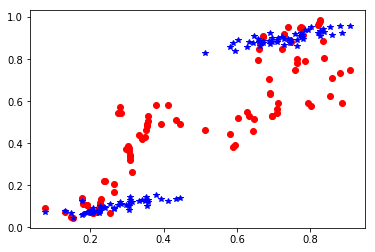

In [414]:
# 学習パラメータにかなり敏感のものですな
plt.plot(test, pred_KR(test, train, sigma, lsif_A), 'ro', label = 'pred')
plt.plot(test, test_y, 'b*', label = 'true')
np.sqrt((pred_KR(test, train, sigma, lsif_A) - test_y)**2).mean()

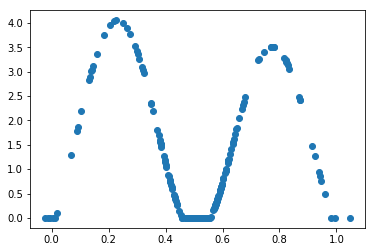

In [367]:
# 各データ点の重み
plt.plot(train, lsif_w[-len(train):], 'o')

# Minimum cross entropy weighted KR

## 重みの算出も含めた学習

In [368]:
def cal_MCEW(train, test):
    # train, test ndarray object number of data(row) × n-dim(column)
    grad = np.log(distance.cdist(train,test)).sum(axis = 1) 
    grad = grad/grad.sum()
    weight = 1 - 1 / grad.max() * grad
    return(weight / weight.sum())

In [369]:
MCE_w = cal_MCEW(train*100, test*100)

In [388]:
MCE_A = learn_KR(train, response,sigma = 0.01, gamma = 0.3, weight = MCE_w*len(train))

## テスト

0.1918281498906407

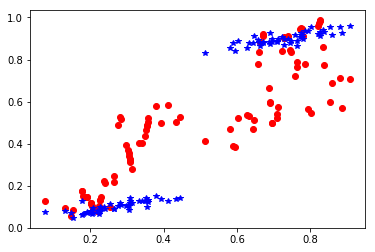

In [406]:
# test data predection
plt.plot(test, pred_KR(test, train, sigma, MCE_A), 'ro', label = 'pred')
plt.plot(test, test_y, 'b*', label = 'true')
np.sqrt((pred_KR(test, train, sigma, MCE_A) - test_y)**2).mean()

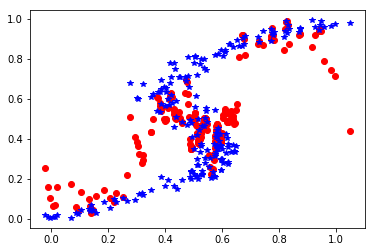

In [390]:
plt.plot(train, pred_KR(train, train, sigma, MCE_A), 'ro', label = 'pred')
plt.plot(train, train_y, 'b*', label = 'true')

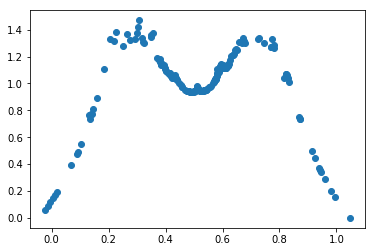

In [391]:
# 各データ点の重み
plt.plot(train, MCE_w*len(train), 'o')